<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5410_HW1_P4_BO_LCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

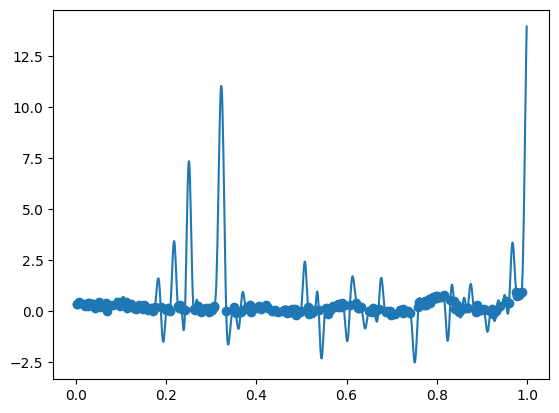

>x=0.544, f()=-2.340, actual=0.289
>x=0.750, f()=-2.393, actual=0.017
>x=0.602, f()=-2.097, actual=0.358
>x=0.910, f()=-0.906, actual=0.100
>x=0.640, f()=-1.370, actual=0.082
>x=0.337, f()=-1.589, actual=0.096
>x=0.947, f()=-1.485, actual=0.345
>x=0.825, f()=-1.567, actual=0.551
>x=0.238, f()=-0.892, actual=0.320
>x=0.248, f()=-1.977, actual=0.210
>x=0.197, f()=-0.645, actual=0.317
>x=0.216, f()=-0.938, actual=0.178
>x=0.927, f()=-0.475, actual=0.297
>x=0.701, f()=-0.250, actual=-0.093
>x=0.363, f()=-0.742, actual=0.069
>x=0.327, f()=-2.878, actual=-0.032
>x=0.755, f()=-0.398, actual=0.177
>x=0.342, f()=-0.640, actual=-0.036
>x=0.715, f()=-0.200, actual=-0.172
>x=0.472, f()=-0.180, actual=-0.119
>x=0.317, f()=-0.295, actual=0.167
>x=0.669, f()=-0.242, actual=0.063
>x=0.687, f()=-0.192, actual=0.117
>x=0.714, f()=-0.251, actual=-0.113
>x=0.853, f()=-0.349, actual=0.044
>x=0.881, f()=-1.651, actual=-0.076
>x=0.935, f()=-0.181, actual=0.127
>x=0.371, f()=-0.161, actual=0.178
>x=0.517, f()

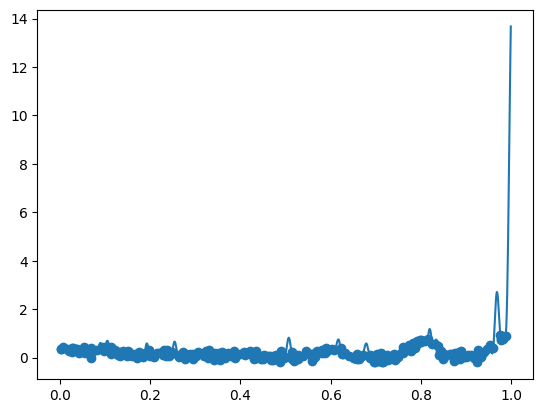

Best Result: x=0.489, y=-0.205


In [7]:
from math import sin, cos, pi
from numpy import arange, vstack, argmin, asarray
from numpy.random import normal, random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from warnings import catch_warnings, simplefilter
from matplotlib import pyplot
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Objective function
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return ((x-0.6) ** 2 + x ** 2 * cos(5 * pi * x) ** 6.0) + noise

# Surrogate function
def surrogate(model, X):
    with catch_warnings():
        simplefilter("ignore")
        return model.predict(X, return_std=True)

# LCB (Lower Confidence Bound) acquisition function
def acquisition(X, Xsamples, model, kappa=1.96):
    mu, std = surrogate(model, Xsamples)
    scores = mu - kappa * std  # Lower confidence bound
    return scores

# Optimize the acquisition function
def opt_acquisition(X, y, model):
    Xsamples = random(100).reshape(-1, 1)
    scores = acquisition(X, Xsamples, model)
    ix = argmin(scores)  # Select the point with the lowest acquisition score
    return Xsamples[ix, 0]

# Plot function
def plot(X, y, model, img_name='plot'):
    pyplot.scatter(X, y)
    Xsamples = asarray(arange(0, 1, 0.001)).reshape(-1, 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    pyplot.show()
    pyplot.close()

# Sample the domain sparsely with noise
X = random(200).reshape(-1, 1)
y = asarray([objective(x) for x in X]).reshape(-1, 1)

# Define the model
kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-2, 10.0))
model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=2)

# Fit the model using X, y
model.fit(X, y)

# Plot before optimization
plot(X, y, model, img_name='gp_initial_model')

# Perform the optimization process
for i in range(100):
    # Select the next point to sample
    x = opt_acquisition(X, y, model)
    # Sample the point
    actual = objective(x)
    # Summarize the finding
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%.3f, actual=%.3f' % (x, est[0], actual))
    # Add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # Update the model
    model.fit(X, y)

# Plot final result
plot(X, y, model, img_name='gp_result_model')

# Best result
ix = argmin(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix].item(), y[ix].item()))